In [35]:
from datetime import datetime
import pandas as pd
import logging
from collections import Counter
import numpy as np
from pycaret.classification import ClassificationExperiment
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [4]:
train_data = pd.read_feather("../data/train_data.ftr")

In [5]:
train_data.shape

(5531451, 191)

In [34]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_140,D_141,D_142,D_143,D_144,D_145,target,Month,Day,Year
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0,3,9,2017
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0,4,7,2017
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0,5,28,2017
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0,6,13,2017
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0,7,16,2017


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(177), int64(1), object(1)
memory usage: 2.0+ GB


In [33]:
# list of column names and their data types
train_data

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,...,NaN,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,...,NaN,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0


In [6]:
# Ensure date column is in datetime format
train_data["S_2"] = pd.to_datetime(train_data["S_2"])

# Sort values by date
train_data = train_data.sort_values("S_2")

In [12]:
# Pick a random sample of 15 percent of the unique customer IDs
customer_ids = train_data["customer_ID"].unique()
np.random.seed(42)
print(f"Number of unique customer IDs: {len(customer_ids)}")
customer_ids_sample = np.random.choice(
    customer_ids, size=int(len(customer_ids) * 0.15), replace=False
)
print(f"Number of unique customer IDs in sample: {len(customer_ids_sample)}")

# Create a dataframe with only the sample customer IDs
train_data_sample = train_data[train_data["customer_ID"].isin(customer_ids_sample)]
print(f"Number of rows in sample: {len(train_data_sample)}")

Number of unique customer IDs: 458913
Number of unique customer IDs in sample: 68836
Number of rows in sample: 829039


In [36]:
train_data_sample.select_dtypes(["category"])
# convert all columns to string type
train_data_sample = train_data_sample.astype(str)

In [37]:
# drop missing values for ML models
train_data_sample.fillna(0, inplace=True)

In [39]:
train_data_sample

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
4389448,cadd5c70135e428aaa7ad1e59c38dc24e690feaaed9bc5...,2017-03-01,0.725,0.3916,0.01929,1.01,0.00576,0.1416,3.33e-05,0.0008254,...,-999.0,-999.0,0.0085,0.003407,0.00827,-999.0,0.004654,0.00946,0.005356,0
220954,0a45aca881a5e9edd01ebf830c2b047dd3d15390fda720...,2017-03-01,0.8457,0.1493,0.02513,1.003,0.00896,0.1454,0.00253,0.000691,...,-999.0,-999.0,0.006416,0.007755,0.007202,-999.0,0.00804,0.00834,0.00677,0
5191152,f01b0814dbd343f8b45090a3cb1346dc394babf1f7577c...,2017-03-01,0.5493,0.008125,0.08575,0.8174,0.00981,0.2096,0.008354,0.006565,...,-999.0,-999.0,-999.0,0.002153,-999.0,-999.0,-999.0,0.006348,-999.0,1
3376072,9bf8e5ce6be315dfc8154f7a03bb8e8285eaa7c36aa921...,2017-03-01,0.9395,0.3594,0.00862,1.008,0.00384,0.1644,0.006535,0.00498,...,-999.0,-999.0,0.009636,0.00918,0.005432,-999.0,0.004864,0.00656,0.007236,0
482517,16766b0bed5c56c373ccfbbee2f95c9ebf982502caa405...,2017-03-01,0.9106,0.002913,0.01004,0.815,0.009705,0.2773,0.00391,0.0107,...,-999.0,-999.0,0.003967,0.0002159,0.00588,-999.0,3.55e-05,6.765e-05,0.00924,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894267,5764f9adade8902858406c9e4f06589e7f53e0caafd8ac...,2018-03-31,0.8945,0.36,0.05554,1.002,0.002172,0.6323,0.0076,0.003761,...,-999.0,-999.0,0.001848,0.002693,0.001192,-999.0,0.002478,0.002457,0.00554,0
263164,0c3c1685f444ee94d332fe10419513c9f88e3d5a22c20e...,2018-03-31,0.996,0.2372,0.03775,1.008,0.00442,0.05338,0.001752,0.00784,...,-999.0,-999.0,0.00637,0.00732,0.002066,-999.0,0.001874,0.005695,0.00607,0
467415,15b817ed1bf82d0b8016e18fc10bd637b897364d8100a3...,2018-03-31,0.4775,0.063,0.5176,0.08325,0.00909,0.145,0.000889,0.3271,...,-999.0,-999.0,1.003,0.00502,0.86,0.000274,1.009,0.009346,0.0924,1
1314489,3c94d2136d8ff4841d28d77ca50e03995992cc34b9bd59...,2018-03-31,0.5015,0.362,0.685,0.02995,0.00415,0.1394,0.001078,1.006,...,-999.0,-999.0,1.001,0.00839,0.866,0.4556,1.003,0.01241,3.002,0


In [38]:
train_data_sample.to_csv("../data/train_data_sample_06_24_2023.csv", index=False)

In [20]:
X = train_data_sample.drop(["target"], axis=1)
y = train_data_sample["target"]

In [21]:
X

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
4389448,cadd5c70135e428aaa7ad1e59c38dc24e690feaaed9bc5...,2017-03-01,0.725098,0.391602,0.019287,1.009766,0.005760,0.141602,0.000033,0.000825,...,NaN,NaN,NaN,0.008499,0.003407,0.008270,NaN,0.004654,0.009460,0.005356
220954,0a45aca881a5e9edd01ebf830c2b047dd3d15390fda720...,2017-03-01,0.845703,0.149292,0.025131,1.002930,0.008957,0.145386,0.002529,0.000691,...,NaN,NaN,NaN,0.006416,0.007755,0.007202,NaN,0.008041,0.008339,0.006771
5191152,f01b0814dbd343f8b45090a3cb1346dc394babf1f7577c...,2017-03-01,0.549316,0.008125,0.085754,0.817383,0.009811,0.209595,0.008354,0.006565,...,NaN,NaN,NaN,NaN,0.002153,NaN,NaN,NaN,0.006348,NaN
3376072,9bf8e5ce6be315dfc8154f7a03bb8e8285eaa7c36aa921...,2017-03-01,0.939453,0.359375,0.008621,1.007812,0.003839,0.164429,0.006535,0.004978,...,NaN,NaN,NaN,0.009636,0.009178,0.005432,NaN,0.004864,0.006561,0.007236
482517,16766b0bed5c56c373ccfbbee2f95c9ebf982502caa405...,2017-03-01,0.910645,0.002913,0.010040,0.814941,0.009705,0.277344,0.003910,0.010696,...,NaN,NaN,NaN,0.003967,0.000216,0.005878,NaN,0.000036,0.000068,0.009239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894267,5764f9adade8902858406c9e4f06589e7f53e0caafd8ac...,2018-03-31,0.894531,0.360107,0.055542,1.001953,0.002172,0.632324,0.007599,0.003761,...,NaN,NaN,NaN,0.001848,0.002693,0.001192,NaN,0.002478,0.002457,0.005539
263164,0c3c1685f444ee94d332fe10419513c9f88e3d5a22c20e...,2018-03-31,0.996094,0.237183,0.037750,1.007812,0.004421,0.053375,0.001752,0.007843,...,NaN,NaN,NaN,0.006371,0.007320,0.002066,NaN,0.001874,0.005695,0.006069
467415,15b817ed1bf82d0b8016e18fc10bd637b897364d8100a3...,2018-03-31,0.477539,0.062988,0.517578,0.083252,0.009087,0.145020,0.000889,0.327148,...,NaN,NaN,NaN,1.002930,0.005020,0.859863,0.000274,1.008789,0.009346,0.092407
1314489,3c94d2136d8ff4841d28d77ca50e03995992cc34b9bd59...,2018-03-31,0.501465,0.362061,0.685059,0.029953,0.004150,0.139404,0.001078,1.005859,...,NaN,NaN,NaN,1.000977,0.008392,0.866211,0.455566,1.002930,0.012413,3.001953


## Pre-process data

In [22]:
# list of feature columns
feature_cols = [col for col in X.columns if col not in ["customer_ID", "S_2", "target"]]
# list of categorical columns
cat_features = [col for col in feature_cols if X[col].dtype in ["category", "object"]]
# list of numerical columns
num_features = [
    col
    for col in feature_cols
    if X[col].dtype not in ["category", "object", "datetime64[ns]"]
]

In [23]:
set(cat_features).intersection(set(num_features))

set()

Split the dataset into train and test sets

In [24]:
print(X[num_features].dtypes)

P_2      float16
D_39     float16
B_1      float16
B_2      float16
R_1      float16
          ...   
D_141    float16
D_142    float16
D_143    float16
D_144    float16
D_145    float16
Length: 177, dtype: object


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Pre-processing

In [26]:
set(num_features).intersection(set(["D_63", "D_64"]))

set()

In [27]:
# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s [%(levelname)s] - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

# Create a pipeline for numerical features
num_pipeline = Pipeline(
    steps=[
        ("num_imputer", SimpleImputer(strategy="median", fill_value=np.nan)),
        ("scaler", StandardScaler()),
    ]
)


# Create a pipeline for categorical features
cat_pipeline = Pipeline(
    steps=[
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("to_str", FunctionTransformer(lambda x: x.astype(str))),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine the pipelines with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features),
    ]
)

# Fit and transform the data
try:
    logger.info("Fitting preprocessor...")
    X_train_preprocessed = preprocessor.fit_transform(X_train)

    logger.info("Transforming test data...")
    X_test_preprocessed = preprocessor.transform(X_test)
except Exception as e:
    logger.error(f"Error occurred while preprocessing data: {e}")

2023-06-23 22:48:10,538 [INFO] - Fitting preprocessor...
2023-06-23 22:48:29,087 [INFO] - Transforming test data...


In [28]:
# get column names of categorical columns that contain alphabets
def get_alpha_cols(df):
    alpha_cols = []
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (str, bytes))).any():
            alpha_cols.append(col)
    return alpha_cols


alpha_cat_columns = get_alpha_cols(train_data_sample[cat_features])
alpha_cat_columns

['D_63', 'D_64']

In [29]:
X["D_64"].value_counts()

O     434684
U     229323
R     126463
       32876
-1      5693
Name: D_64, dtype: int64

In [30]:
# Process categorical columns via one-hot encoding
train_data_sample = pd.get_dummies(train_data_sample, columns=alpha_cat_columns)

In [31]:
train_data_sample.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_63_CO', 'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ', 'D_64_',
       'D_64_-1', 'D_64_O', 'D_64_R', 'D_64_U'],
      dtype='object', length=200)

The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [7]:
count_of_feature_type = Counter(
    [x.split("_")[0] for x in train_data.columns if x not in ["customer_ID", "target"]]
)
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=["count"]).T
count_of_feature_type

,count
S,22
P,3
D,105
B,40
R,28


### Imbalance Data

0    0.750738
1    0.249262
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

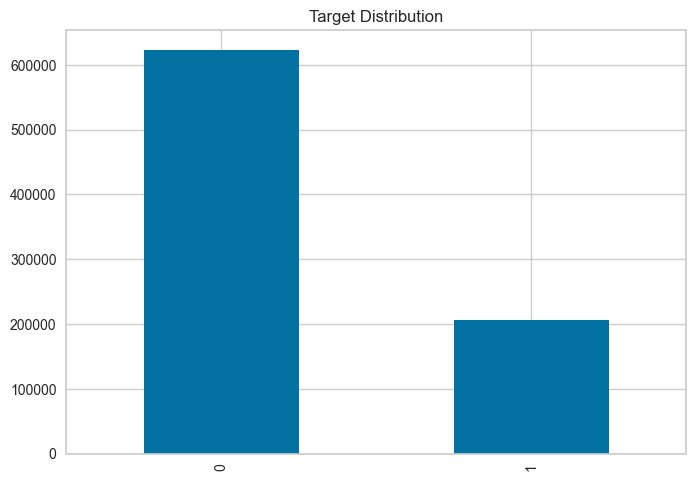

In [8]:
# calculate the percentage of training data that is 1 and 0
print(train_data["target"].value_counts(normalize=True))
train_data["target"].value_counts().plot(kind="bar", title="Target Distribution")

In [9]:
train_data = train_data.sort_values(by=["customer_ID", "S_2"])

In [10]:
# Extract the date information from the date column
train_data["Month"] = [i.month for i in train_data["S_2"]]
train_data["Day"] = [i.day for i in train_data["S_2"]]
train_data["Year"] = [i.year for i in train_data["S_2"]]

In [11]:
# pick random sample of customer_IDs from train_data
np.random.seed(42)
customer_ID_rand = np.random.choice(train_data["customer_ID"], 10000, replace=False)

In [12]:
train_rndm_sample = train_data[train_data["customer_ID"].isin(customer_ID_rand)]

<AxesSubplot: title={'center': 'Number of rows per customer'}, ylabel='Frequency'>

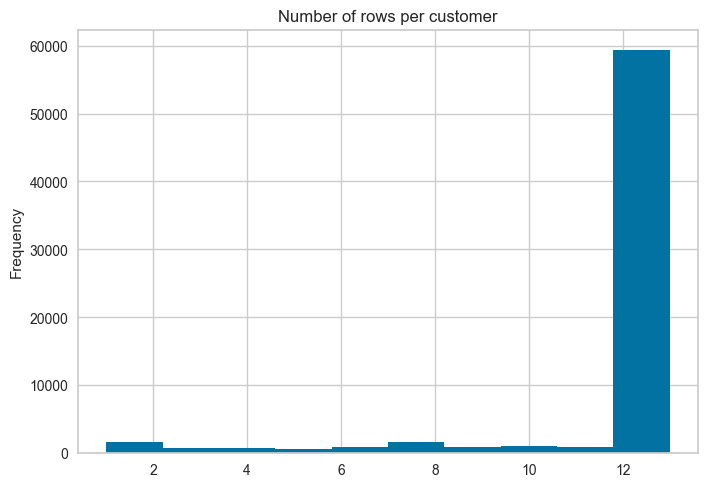

In [13]:
# calculate and plot the number of rows of data for each customer
customer_count = train_data_sample["customer_ID"].value_counts()
customer_count.plot(kind="hist", title="Number of rows per customer")

In [14]:
# customer_IDs that are not in the random sample for the training data
customer_ID_not_train = list(
    set(train_data["customer_ID"]).difference(set(customer_ID_rand))
)

# pick random sample of customer_IDs from customer_ID_not_train
customer_ID_test_rnd = np.random.choice(customer_ID_not_train, 10000, replace=False)

# test data based on the random sample of customer_IDs
test_rndm_sample = train_data[
    train_data["customer_ID"].isin(customer_ID_test_rnd)
].sort_values(by=["customer_ID", "S_2"])

In [15]:
test_rndm_sample.shape

(120465, 194)

In [16]:
# drop customer_ID and S_2 from train and test data
train_rndm_sample.drop(["customer_ID", "S_2"], axis=1, inplace=True)
test_rndm_sample.drop(["customer_ID", "S_2"], axis=1, inplace=True)

0    0.750738
1    0.249262
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

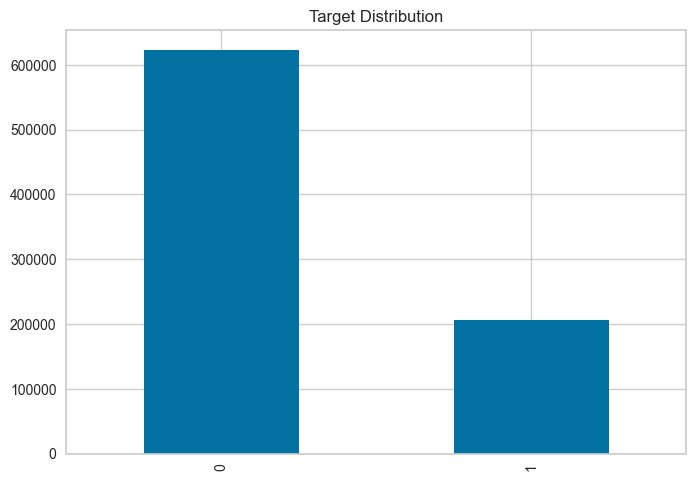

In [17]:
# calculate the percentage of training data sample that is 1 and 0
print(train_rndm_sample["target"].value_counts(normalize=True))
train_rndm_sample["target"].value_counts().plot(kind="bar", title="Target Distribution")

In [18]:
s = ClassificationExperiment()
s.setup(
    data=train_rndm_sample,
    target="target",
    normalize=True,
    session_id=123,
    fix_imbalance=True,
)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(124538, 192)"
4,Transformed data shape,"(171126, 223)"
5,Transformed train set shape,"(133764, 223)"
6,Transformed test set shape,"(37362, 223)"
7,Ordinal features,4
8,Numeric features,180
9,Categorical features,11


In [21]:
s.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [49]:
number_of_models = len(s.models())
compare_models_all = s.compare_models(n_select=number_of_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9610,0.9921,0.9448,0.8936,0.9185,0.8928,0.8934,3.9730
knn,K Neighbors Classifier,0.9509,0.9899,0.9757,0.8397,0.9026,0.8700,0.8744,4.6070
catboost,CatBoost Classifier,0.9411,0.9814,0.8670,0.8784,0.8726,0.8343,0.8343,13.5530
xgboost,Extreme Gradient Boosting,0.9251,0.9739,0.8423,0.8372,0.8397,0.7909,0.7909,22.9570
rf,Random Forest Classifier,0.9199,0.9725,0.9058,0.7838,0.8404,0.7873,0.7910,15.3500
lightgbm,Light Gradient Boosting Machine,0.8988,0.9574,0.8075,0.7692,0.7879,0.7214,0.7218,2.4430
gbc,Gradient Boosting Classifier,0.8686,0.9347,0.8075,0.6848,0.7411,0.6539,0.6579,46.4040
dt,Decision Tree Classifier,0.8677,0.8278,0.7530,0.7011,0.7261,0.6390,0.6398,5.4460
lr,Logistic Regression,0.8555,0.9355,0.8836,0.6368,0.7401,0.6437,0.6603,2.2520
ada,Ada Boost Classifier,0.8555,0.9213,0.7849,0.6594,0.7167,0.6207,0.6249,9.5610


Processing:   0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
pred_scores_df = pd.DataFrame()
for x in compare_models_all:
    df_pred = s.predict_model(
        x,
        data=test_rndm_sample,
    )
    x = s.pull()
    pred_scores_df = pd.concat([pred_scores_df, x])

In [66]:
pred_scores_df.sort_values(by=["Accuracy"], ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8689,0.9321,0.7625,0.7336,0.7477,0.6592,0.6594
0,CatBoost Classifier,0.8678,0.9311,0.7337,0.7442,0.7389,0.6504,0.6505
0,Extreme Gradient Boosting,0.8626,0.9257,0.7224,0.7342,0.7283,0.6363,0.6364
0,Gradient Boosting Classifier,0.8610,0.9279,0.8105,0.6948,0.7482,0.6529,0.6566
0,Random Forest Classifier,0.8600,0.9251,0.8117,0.6921,0.7472,0.6512,0.6551
0,Extra Trees Classifier,0.8559,0.9239,0.7991,0.6867,0.7387,0.6399,0.6435
0,Ada Boost Classifier,0.8512,0.9188,0.8039,0.6747,0.7336,0.6315,0.6362
0,Logistic Regression,0.8501,0.9291,0.8825,0.6522,0.7501,0.6465,0.6616
0,Ridge Classifier,0.8444,0.8619,0.8974,0.6386,0.7462,0.6386,0.6578
0,Linear Discriminant Analysis,0.8444,0.9292,0.8975,0.6386,0.7463,0.6386,0.6579


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9983,1.0000,0.9966,0.9967,0.9966,0.9955,0.9955,55.4380


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
for model in compare_models_all:
    s.save_model(model, '../models_saved/'+model.__class__.__name__)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


## LSTM model

In [49]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import AUC

In [51]:
# Sort the data by customer and then by month
df = train_data_sample.copy()
df = df.groupby("customer_ID").filter(lambda x: len(x) <= 13)


# Sort the data by customer and then by date


df["date"] = pd.to_datetime(df["S_2"])
df.drop(["S_2"], axis=1, inplace=True)
df.sort_values(["customer_ID", "date"], inplace=True)
categorical_columns = df.select_dtypes(include=["category"]).columns
categorical_columns
df = pd.get_dummies(df, columns=categorical_columns)

In [52]:
print(df.isna().sum())  # Summarize the count of NaNs by column
print(
    df.isin([np.inf, -np.inf]).sum()
)  # Summarize the count of infinite values by column

customer_ID       0
P_2            6723
D_39              0
B_1               0
B_2             288
               ... 
D_120_0.0         0
D_120_1.0         0
D_126_-1.0        0
D_126_0.0         0
D_126_1.0         0
Length: 226, dtype: int64
customer_ID    0
P_2            0
D_39           0
B_1            0
B_2            0
              ..
D_120_0.0      0
D_120_1.0      0
D_126_-1.0     0
D_126_0.0      0
D_126_1.0      0
Length: 226, dtype: int64


In [53]:
df.fillna(
    df.median(), inplace=True
)  # Replace NaNs with the median value of each column
df.replace(
    [np.inf, -np.inf], np.finfo(np.float32).max, inplace=True
)  # Replace infinite values with the max float32 value

In [54]:
df.dtypes

customer_ID     object
P_2            float16
D_39           float16
B_1            float16
B_2            float16
                ...   
D_120_0.0        uint8
D_120_1.0        uint8
D_126_-1.0       uint8
D_126_0.0        uint8
D_126_1.0        uint8
Length: 226, dtype: object

In [25]:
from sklearn.preprocessing import StandardScaler

# Assume df is your original dataframe

# features = df.drop('customer_ID', axis=1)  # drop the customer_ID column
float16_columns = df.select_dtypes(include=["float16"]).columns

scaler = StandardScaler()
df[float16_columns] = scaler.fit_transform(df[float16_columns])

# If you need to keep the customer_ID in the dataframe for later use, you can add it back

In [26]:
len([x for x in df.columns if x not in ["customer_ID", "target", "date"]])

223

In [27]:
def get_max_len_and_index_map(df):
    unique_customers = df["customer_ID"].unique()
    customer_index_map = {
        customer: idx for idx, customer in enumerate(unique_customers)
    }
    max_len = 0

    for customer in tqdm(
        unique_customers, desc="Getting max length", total=len(unique_customers)
    ):
        customer_data = df[df["customer_ID"] == customer]
        max_len = max(max_len, len(customer_data))

    return max_len, customer_index_map

In [28]:
def reshape_data(df, max_len, customer_index_map):
    num_customers = len(customer_index_map)
    num_features = df.drop(["customer_ID", "date", "target"], axis=1).shape[1]
    X = np.zeros((num_customers, max_len - 12, 12, num_features))
    y = np.zeros((num_customers, max_len - 12))
    mask = np.zeros((num_customers, max_len - 12), dtype=bool)

    df["customer_index"] = df["customer_ID"].map(customer_index_map)
    customer_data = df.groupby("customer_index").apply(
        lambda x: x.drop(["customer_ID", "date", "target"], axis=1).values
    )

    for idx, data in customer_data.items():
        num_rows = data.shape[0] - 12 if data.shape[0] > 12 else 0
        if num_rows > 0:
            X[idx, :num_rows] = np.stack(
                [data[i : i + 12] for i in range(num_rows)], axis=0
            )
            y[idx, :num_rows] = df.loc[df["customer_index"] == idx, "target"].values[
                12:
            ]
            mask[idx, :num_rows] = True
        elif (
            data.shape[0] > 0
        ):  # handle the case where a customer has less than 12 months of data
            X[idx, 0, : data.shape[0]] = data
            mask[idx, 0] = True

    return X.reshape(-1, 12, num_features), y.reshape(-1), mask.reshape(-1)

In [29]:
max_len, customer_index_map = get_max_len_and_index_map(df)

Getting max length: 100%|██████████| 19596/19596 [02:15<00:00, 144.95it/s]


In [31]:
X, y, mask = reshape_data(df, max_len, customer_index_map)

In [32]:
X.shape

(19596, 12, 224)

In [33]:
# Normalizing the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
mask_torch = torch.tensor(mask, dtype=torch.bool)

# Train-test split
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    X, y, mask_torch, test_size=0.2, random_state=42
)

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train, mask_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test, mask_test)

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [34]:
mask_torch.shape

torch.Size([19596])

In [35]:
import torch.nn as nn


class CreditDefaultNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CreditDefaultNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        # Add an extra dimension to the end of the tensor
        out = out.unsqueeze(-1)

        return out

In [42]:
# Define the model
import torch

device = torch.device("mps")

model = CreditDefaultNet(
    input_size=224, hidden_size=64, num_layers=2, output_size=1
).to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100
train_losses = []
for epoch in range(num_epochs):
    for i, (inputs, labels, mask) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        # Forward pass
        outputs = model(inputs).squeeze(
            1
        )  # outputs shape should be [batch_size] to match mask shape

        # print("Outputs shape:", outputs.shape)
        # print("Labels shape:", labels.shape)
        # print("Mask shape:", mask.shape)

        # mask = mask.view(-1)

        # Reshape the labels to match the outputs
        labels = labels.unsqueeze(1)

        loss = criterion(outputs[mask], labels[mask])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        if (i + 1) % 200 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}"
            )
            train_losses.append(loss.item())

Epoch [1/100], Step [200/490], Loss: 0.3195
Epoch [1/100], Step [400/490], Loss: 0.2044
Epoch [2/100], Step [200/490], Loss: 0.2496
Epoch [2/100], Step [400/490], Loss: 0.1944
Epoch [3/100], Step [200/490], Loss: 0.2347
Epoch [3/100], Step [400/490], Loss: 0.1926
Epoch [4/100], Step [200/490], Loss: 0.2287
Epoch [4/100], Step [400/490], Loss: 0.1909
Epoch [5/100], Step [200/490], Loss: 0.2286
Epoch [5/100], Step [400/490], Loss: 0.1859
Epoch [6/100], Step [200/490], Loss: 0.2295
Epoch [6/100], Step [400/490], Loss: 0.1793
Epoch [7/100], Step [200/490], Loss: 0.2290
Epoch [7/100], Step [400/490], Loss: 0.1716
Epoch [8/100], Step [200/490], Loss: 0.2276
Epoch [8/100], Step [400/490], Loss: 0.1635
Epoch [9/100], Step [200/490], Loss: 0.2268
Epoch [9/100], Step [400/490], Loss: 0.1557
Epoch [10/100], Step [200/490], Loss: 0.2268
Epoch [10/100], Step [400/490], Loss: 0.1486
Epoch [11/100], Step [200/490], Loss: 0.2276
Epoch [11/100], Step [400/490], Loss: 0.1423
Epoch [12/100], Step [200/49

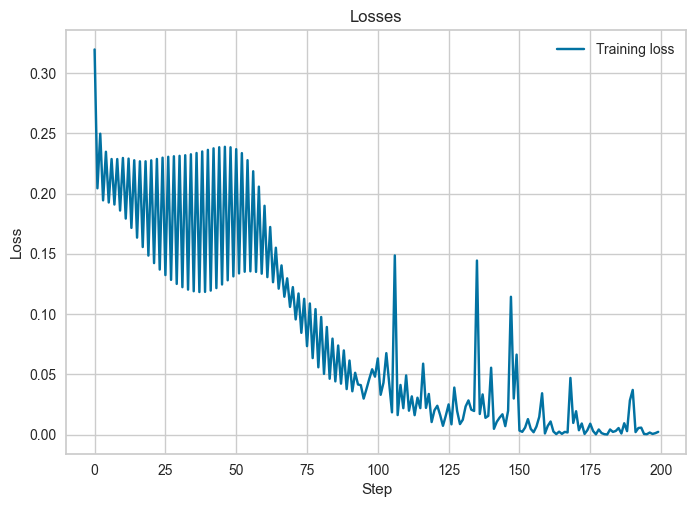

In [43]:
import matplotlib.pyplot as plt

# Plot the training losses
plt.plot(train_losses, label="Training loss")
plt.title("Losses")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
torch.save(model, "../models/credit_default_model_05_18_2023.pt")

In [45]:
test_dataset = TensorDataset(X_test, y_test, mask_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()  # set the model to evaluation mode

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels, mask in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        # Forward pass
        # Forward pass
        outputs = model(inputs).squeeze()

        # Compute test loss
        loss = criterion(outputs[mask], labels[mask])
        test_loss += loss.item()

        # Convert model output probabilities to predicted class (0 or 1)
        predicted = torch.round(
            torch.sigmoid(outputs)
        )  # Sigmoid function to convert output to a probability that sum up to 1
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

# Print test metrics
print("Test Loss: ", test_loss / len(test_loader))
print("Test Accuracy: ", correct / total)

Test Loss:  0.8837281699951102
Test Accuracy:  0.8714285714285714
